In [39]:
import pandas as pd
import numpy as np
import collections

In [40]:
submissions_train = pd.read_csv("submissions.csv", delimiter=';')

In [41]:
drop_cols = ['attempt_time']
if isinstance(drop_cols, str) or (not isinstance(drop_cols, collections.Iterable)):
        drop_cols = [drop_cols]
drop_col_names = np.intersect1d(submissions_train.columns, drop_cols)
submissions_train.drop(drop_col_names, axis=1, inplace=True)

In [42]:
submissions_train['date'] = pd.to_datetime(submissions_train.submission_time, unit='s')
submissions_train['day'] = submissions_train.date.dt.date

In [43]:
n_day = 1
users_min_time = submissions_train.groupby('user_id', as_index=False).agg({'submission_time': 'min'}).rename(
        {'submission_time': 'min_timestamp'}, axis=1)
users_min_time['min_timestamp'] += 60 * 60 * 24 * n_day
submission_data_d = pd.merge(submissions_train, users_min_time, how='inner', on='user_id')
cond = submission_data_d['submission_time'] <= submission_data_d['min_timestamp']
submission_data_d = submission_data_d[cond]
submissions = submission_data_d

In [44]:
# таблица с данными по каждому пользователю
users_data = submissions.groupby('user_id', as_index=False).agg({'submission_time': 'max'}).rename(columns={'submission_time': 'last_timestamp'})
# попытки сдачи практики пользователя
users_scores = submissions.pivot_table(index='user_id',
                                           columns='status',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)
# колво дней на курсе
users_days = submissions.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

In [45]:
sertificate = pd.read_csv(f"sertificate.csv", delimiter=';')
sertificate['certificate_url'] = pd.isna(sertificate['certificate_url'])
users_data = users_data.merge(sertificate, on='user_id', how='outer')
users_data = users_data[:834]
users_data['certificate_url'] = users_data.certificate_url.fillna(False)
users_data['certificate_url'] = users_data['certificate_url'].astype('int32')

In [46]:
cheating = pd.read_csv("cheating_prohib.csv", delimiter=';')
all_cheating = (cheating.groupby('user_id', as_index=False)['cheating_probability (%)']
                .agg({'cheating_probability (%)': lambda a: sum(a)//len(a)})
                .rename(columns={'step_id': cheating}))

In [47]:
users_data = users_data.merge(all_cheating, on='user_id', how='outer')
users_data = users_data.rename(columns={'cheating_probability (%)': 'cheating'})
users_data['cheating'] = users_data.cheating.fillna(0)

In [48]:
comments = pd.read_csv(f"comments.csv", delimiter=';')

In [49]:
comments['date'] = pd.to_datetime(comments.time_utc, unit='s')
comments['day'] = comments.date.dt.date

In [50]:
n_day = 1
users_min_time = comments.groupby('user_id', as_index=False).agg({'time_utc': 'min'}).rename(
        {'time_utc': 'min_timestamp'}, axis=1)
users_min_time['min_timestamp'] += 60 * 60 * 24 * n_day
comments_data_d = pd.merge(comments, users_min_time, how='inner', on='user_id')
cond = comments_data_d['time_utc'] <= comments_data_d['min_timestamp']
comments_data_dsubmission_data_d = comments_data_d[cond]
all_comments = comments_data_d

In [51]:
all_comments = all_comments.drop(['step_id', 'time_utc', 'date', 'day', 'min_timestamp'], axis=1)

In [52]:
answer_comments = (all_comments.groupby('user_id', as_index=False)['comment_id']
                .agg({'comments': lambda a: len(a)}))

In [53]:
users_data = users_data.merge(answer_comments, on='user_id', how='outer')

In [54]:
users_data['comments'] = users_data.comments.fillna(0)

In [55]:
users_data = users_data[:834]

In [56]:
X = users_data.drop(['user_id', 'certificate_url'], axis=1)
y = users_data['certificate_url']

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [59]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2, 
                            min_samples_leaf=10, min_samples_split=10, 
                            class_weight='balanced', max_depth=5)

rf.fit(X_train, y_train)
pred_proba = rf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.7954805491990846


In [60]:
# важность фич
fimp = pd.DataFrame([rf.feature_importances_], columns=X_train.columns).T
fimp.columns = ['weight']
fimp.sort_values('weight', ascending=False)
fimp.head(15)

weight
last_timestamp  0.183236
correct         0.426048
wrong           0.171722
day             0.027773
cheating        0.153422
comments        0.037799

In [61]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train,y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
from catboost import Pool, cv
params = {"iterations": 100,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False}
cv_dataset = Pool(data=X_train,
                  label=y_train)
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

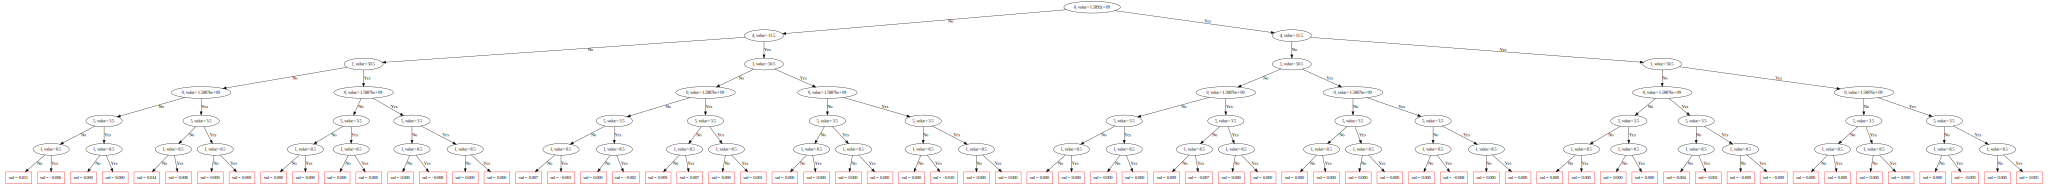

In [63]:
cat.plot_tree(tree_idx=0)

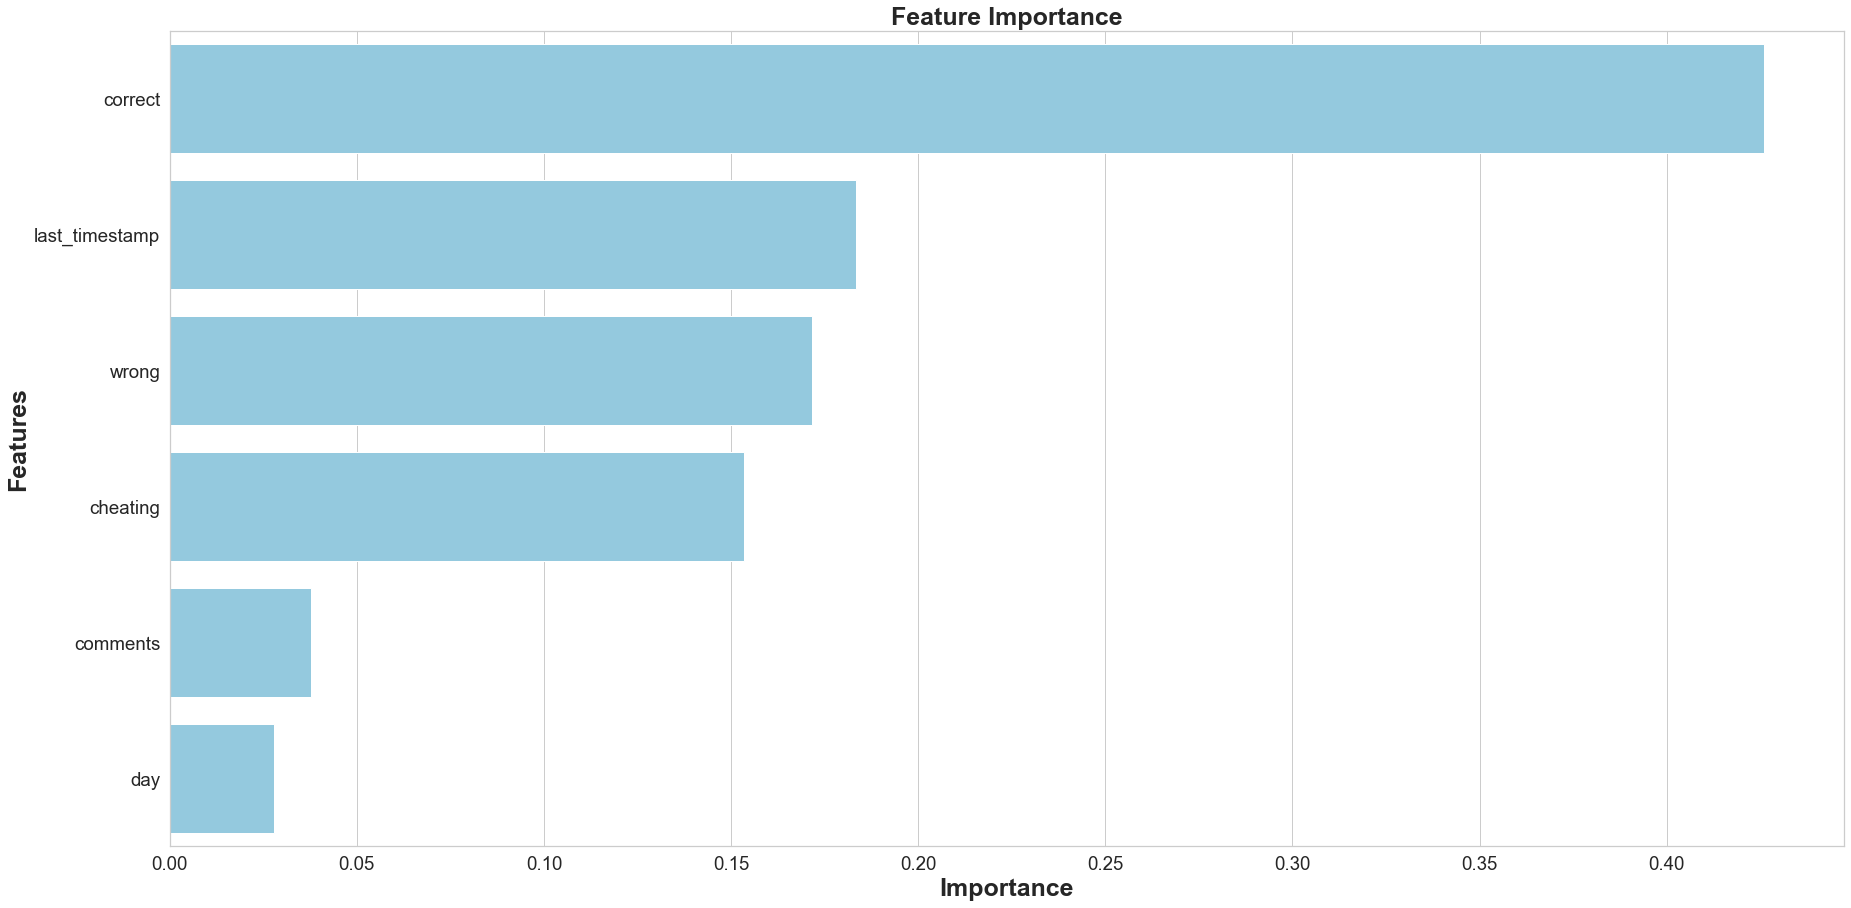

None

Features  Gini-Importance
0         correct         0.426048
1  last_timestamp         0.183236
2           wrong         0.171722
3        cheating         0.153422
4        comments         0.037799
5             day         0.027773

In [64]:
import seaborn as sns
feats = {}
for feature, importance in zip(X_train.columns, rf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [66]:
rs = 42
clf = LogisticRegression(random_state=rs)
clf2 = RandomForestClassifier(random_state=rs, n_jobs =-1)
clf3 = SGDClassifier()
clf4 = SVC(random_state =rs)
clf5 = DecisionTreeClassifier(random_state=rs)
clf6 = SVC(class_weight="balanced", random_state =rs)
clf7 = DecisionTreeClassifier()
clf8 = ExtraTreeClassifier()
clf10 = LogisticRegressionCV() 


In [67]:
clflist = [clf, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf10]

LogisticRegression(random_state=42)
Precision:   0.27
Recall:   0.50
F1-measure:   0.35
Accuracy:   0.55
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71        46
         1.0       0.00      0.00      0.00        38

    accuracy                           0.55        84
   macro avg       0.27      0.50      0.35        84
weighted avg       0.30      0.55      0.39        84



C:\Users\Sofia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sofia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


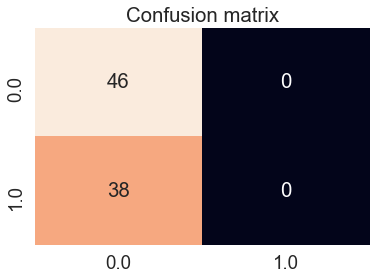

RandomForestClassifier(n_jobs=-1, random_state=42)
Precision:   0.68
Recall:   0.67
F1-measure:   0.67
Accuracy:   0.68
              precision    recall  f1-score   support

         0.0       0.68      0.78      0.73        46
         1.0       0.68      0.55      0.61        38

    accuracy                           0.68        84
   macro avg       0.68      0.67      0.67        84
weighted avg       0.68      0.68      0.67        84



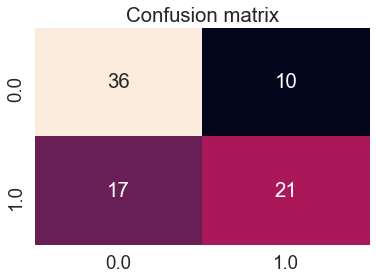

SGDClassifier()
Precision:   0.27
Recall:   0.50
F1-measure:   0.35
Accuracy:   0.55
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71        46
         1.0       0.00      0.00      0.00        38

    accuracy                           0.55        84
   macro avg       0.27      0.50      0.35        84
weighted avg       0.30      0.55      0.39        84



C:\Users\Sofia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sofia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


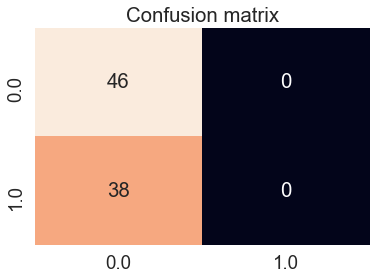

SVC(random_state=42)
Precision:   0.27
Recall:   0.50
F1-measure:   0.35
Accuracy:   0.55
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71        46
         1.0       0.00      0.00      0.00        38

    accuracy                           0.55        84
   macro avg       0.27      0.50      0.35        84
weighted avg       0.30      0.55      0.39        84



C:\Users\Sofia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sofia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


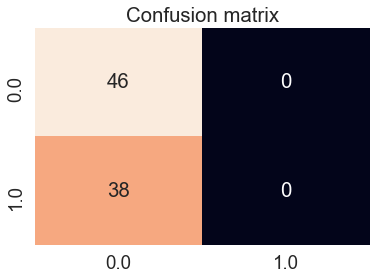

DecisionTreeClassifier(random_state=42)
Precision:   0.66
Recall:   0.67
F1-measure:   0.66
Accuracy:   0.67
              precision    recall  f1-score   support

         0.0       0.70      0.67      0.69        46
         1.0       0.62      0.66      0.64        38

    accuracy                           0.67        84
   macro avg       0.66      0.67      0.66        84
weighted avg       0.67      0.67      0.67        84



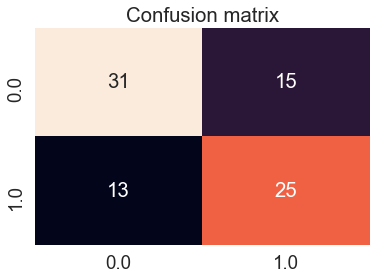

SVC(class_weight='balanced', random_state=42)
Precision:   0.51
Recall:   0.50
F1-measure:   0.45
Accuracy:   0.54
              precision    recall  f1-score   support

         0.0       0.55      0.85      0.67        46
         1.0       0.46      0.16      0.24        38

    accuracy                           0.54        84
   macro avg       0.51      0.50      0.45        84
weighted avg       0.51      0.54      0.47        84



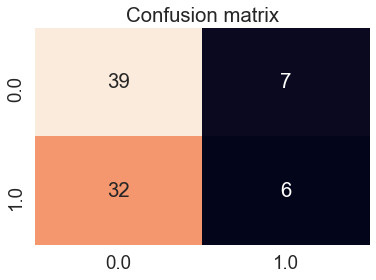

DecisionTreeClassifier()
Precision:   0.62
Recall:   0.62
F1-measure:   0.62
Accuracy:   0.62
              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64        46
         1.0       0.57      0.63      0.60        38

    accuracy                           0.62        84
   macro avg       0.62      0.62      0.62        84
weighted avg       0.62      0.62      0.62        84



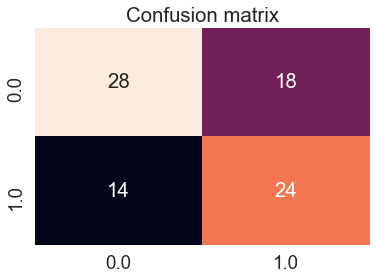

ExtraTreeClassifier()
Precision:   0.60
Recall:   0.60
F1-measure:   0.60
Accuracy:   0.61
              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65        46
         1.0       0.57      0.53      0.55        38

    accuracy                           0.61        84
   macro avg       0.60      0.60      0.60        84
weighted avg       0.60      0.61      0.61        84



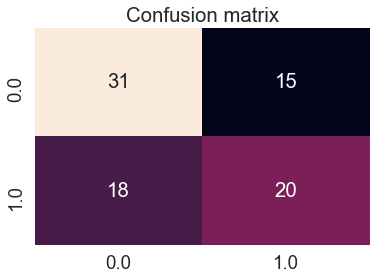

LogisticRegressionCV()
Precision:   0.27
Recall:   0.50
F1-measure:   0.35
Accuracy:   0.55
              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71        46
         1.0       0.00      0.00      0.00        38

    accuracy                           0.55        84
   macro avg       0.27      0.50      0.35        84
weighted avg       0.30      0.55      0.39        84



C:\Users\Sofia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sofia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


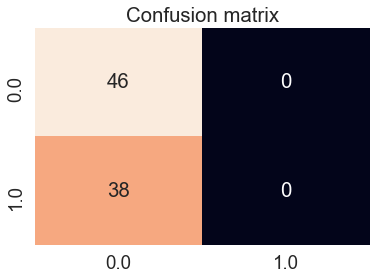

In [68]:
for classif in clflist:
    clf = classif
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(classif)
    print("Precision: {0:6.2f}".format(metrics.precision_score(y_test, predictions, average='macro')))
    print("Recall: {0:6.2f}".format(metrics.recall_score(y_test, predictions, average='macro')))
    print("F1-measure: {0:6.2f}".format(metrics.f1_score(y_test, predictions, average='macro')))
    print("Accuracy: {0:6.2f}".format(metrics.accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))
    labels = clf.classes_
    sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix")
    plt.show()

In [69]:
estimator_limited = rf.estimators_[5]
estimator_nonlimited = rf.estimators_[5]

from sklearn.tree import export_graphviz
export_graphviz(estimator_limited, out_file='tree_limited.dot',
                rounded = True, proportion = False, precision = 2, filled = True)
                
export_graphviz(estimator_nonlimited, out_file='tree_nonlimited.dot',
                rounded = True, proportion = False, precision = 2, filled = True)
                
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

from IPython.display import Image
Image(filename = 'tree_limited.png')

!dot -Tpng tree_nonlimited.dot -o tree_nonlimited.png -Gdpi=600

Image(filename = 'tree_nonlimited.png')